# DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement. Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set. Strategies you might use include:

- Creating new features
- Applying more overfitting-prevention strategies like subsampling
- More iterations
- Trying a different loss function
- Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!


In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


The *ppltrst*, *pplfair*, and *pplhlp* features are all out of 10. Since being fair, trusting and helpful are all traits of people (or possibly how the surveyed person views people, depending on the description of the features), we can average these and combine them in a feature called society. Moreover, values for this feature shall be rounded in order to have categorical rather than continuous values, so they can fit with the classifier:

In [3]:
df['society'] = round((df['pplfair'] + df['ppltrst'] + df['pplhlp'])/3)

Next, we'll drop the 3 columns that begin with *ppl*, in addition to the *idno* columns (which means ID number), and the *cntry* columns, because while living conditions vary, the ultimate and long-term factors of happiness do not relate to a certain country:

In [4]:
df = df.drop(columns=['idno', 'pplfair','ppltrst','pplhlp','cntry']).head()
df.head()

,year,tvtot,happy,sclmeet,sclact,gndr,agea,partner,society
0,6,3.0,8.0,5.0,4.0,2.0,60.0,1.0,6.0
1,6,6.0,9.0,3.0,2.0,2.0,59.0,1.0,6.0
2,6,1.0,7.0,6.0,3.0,1.0,24.0,2.0,8.0
3,6,4.0,10.0,6.0,2.0,2.0,64.0,1.0,6.0
4,6,5.0,8.0,7.0,2.0,2.0,55.0,1.0,6.0


Now we are ready for model preparation:

In [5]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner'])]#, 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
# X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Drop columns
# X.drop(columns=['pplfair', 'ppltrst', 'pplhlp'],inplace=True)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [6]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: col_0
0.0    1.0
All    1.0
Name: 0.0, dtype: float64
Percent Type II errors: col_0
0.0    1.0
All    1.0
Name: 0.0, dtype: float64


In [7]:
clf.score(X_test,y_test)

1.0

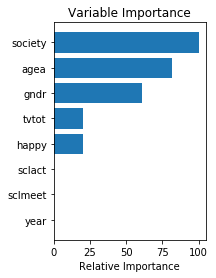

In [8]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()